# Классификация для предсказания CC50

* В данном ноутбуке проводится сравнение моделей классификации для задачи предсказания бинарного признака на основе CC50.  
Оцениваются метрики качества (Accuracy, Precision, Recall, F1, ROC-AUC), выполняется визуализация и делается вывод о наиболее эффективной модели.


* **CC50 (Cytotoxic Concentration 50%)** — концентрация вещества, при которой наблюдается 50% снижение жизнеспособности клеток.  
Показатель широко используется в фармацевтике для оценки цитотоксичности соединений.




In [5]:
!pip install catboost xgboost scikit-learn matplotlib seaborn joblib pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [44]:
# Стандартные библиотеки для работы с массивами, таблицами и визуализацией
import numpy as np                          # работа с числовыми массивами и векторами
import pandas as pd                        # обработка таблиц и датафреймов
import matplotlib.pyplot as plt            # базовая визуализация графиков
import seaborn as sns                      # улучшенные графики и тепловые карты

# Модель логистической регрессии (для бинарной классификации)
from sklearn.linear_model import LogisticRegression

# Метрики для оценки качества классификации: точность, полнота, F1, AUC и матрица ошибок
from sklearn.metrics import (accuracy_score, roc_auc_score,
                           f1_score, precision_score,
                           recall_score, confusion_matrix)

# Алгоритм, который относит объект к классу, наиболее часто встречающемуся среди его ближайших соседей в пространстве признаков.
from sklearn.neighbors import KNeighborsClassifier

# Градиентный бустинг от Яндекса — хорошо работает с категориальными признаками
from catboost import CatBoostClassifier

# Градиентный бустинг от XGBoost — мощная модель для работы с табличными данными
from xgboost import XGBClassifier

# Быстрый градиентный бустинг от sklearn (без внешних зависимостей)
from sklearn.ensemble import HistGradientBoostingClassifier

# Случайный лес — классический ансамблевый метод на основе деревьев
from sklearn.ensemble import RandomForestClassifier

# Функция для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

In [109]:
# === Загружаем Датасет ===
df = pd.read_excel("/content/sample_data/1.xlsx")
df = df.drop_duplicates()
print(f"Размерность набора данных: {df.shape}")
display(df.head())
df.info()

# Альтернативный способ загрузки данных для ментора, если возникают проблемы с загрузкой файла
# Excel = 'https://lms.skillfactory.ru/asset-v1:SkillFactory+MIFIML-2sem+2025+type@asset+block@%D0%94%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D0%B4%D0%BB%D1%8F_%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%BE%D0%B8__%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%9C%D0%9E.xlsx'
# df = pd.read_excel(Excel)

Размерность набора данных: (1001, 214)


,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Columns: 214 entries, Unnamed: 0 to fr_urea
dtypes: float64(107), int64(107)
memory usage: 1.6 MB


In [110]:
target = 'CC50, mM'
cols_to_drop= ['IC50, mM', 'SI', 'Unnamed: 0']
df = df.drop(cols_to_drop, axis=1)
original_count = len(df)
print(f"Исходное количество записей: {original_count}")

Исходное количество записей: 1001


In [47]:
mean_cc50 = df[target].mean()
std_cc50 = df[target].std()
lower_bound = mean_cc50 - 2 * std_cc50
upper_bound = mean_cc50 + 2 * std_cc50

df = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)].copy()

filtered_count = len(df)
print(f"Количество записей после удаления выбросов: {filtered_count}")
print(f"Удалено записей: {original_count - filtered_count}")


Количество записей после удаления выбросов: 945
Удалено записей: 56


In [48]:
# Создание целевой переменной
df['CC50_Median'] = (df[target] > df[target].median()).astype(int)
target = 'CC50_Median'

In [49]:
RANDOM_STATE = 123

In [50]:
# Исключаем ненужные столбцы
cols_to_exclude = ['IC50, mM', 'CC50, mM', 'SI', target]
X = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')
y = df[target]


In [51]:
df_regress = X.copy()

# Добавление новых признаков молярный
df_regress['MolLogP_MolWt'] = df_regress['MolLogP'] * df_regress['MolWt']

In [52]:
# Полиномиальные признаки
existing_poly_cols = [col for col in ['MolLogP', 'MolWt'] if col in df_regress.columns]

In [53]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df_regress[existing_poly_cols])
poly_feature_names = poly.get_feature_names_out(existing_poly_cols)

new_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_regress.index)
for col in new_poly_df.columns:
   if col not in df_regress.columns:
       df_regress[col] = new_poly_df[col]

In [54]:
df_regress['MolLogP_gt_3'] = (df_regress['MolLogP'] > 3).astype(int)

In [55]:
imputer = SimpleImputer(strategy='median')
df_regress = pd.DataFrame(imputer.fit_transform(df_regress), columns=df_regress.columns)

In [56]:
print("Получили новые признаки:", [col for col in df_regress.columns if col not in df.columns])

Получили новые признаки: ['MolLogP_MolWt', 'MolLogP^2', 'MolLogP MolWt', 'MolWt^2', 'MolLogP_gt_3']


In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_regress, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


In [58]:
results = []

**Logistic Regression**

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score,
                           f1_score, precision_score,
                           recall_score, confusion_matrix)

In [62]:
#Обучение и прогноз модели логистической регрессии

name = 'Logistic Regression'
model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Построим **Confusion Matrix** - это таблица, которая показывает, сколько объектов каждого класса модель предсказала правильно и с какими именно ошибками, сравнивает истинные и предсказанные значения.

/tmp/ipython-input-63-2860265789.py:21: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


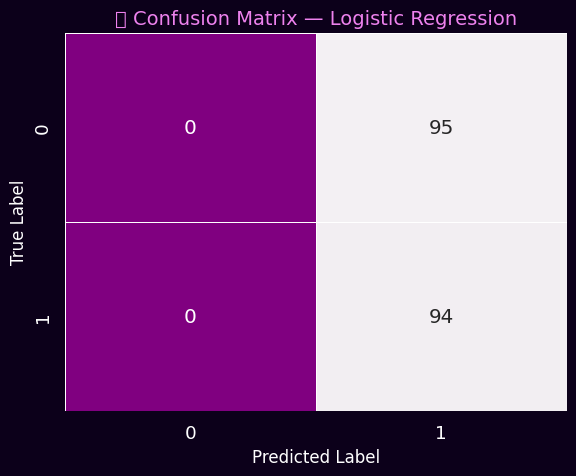

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d',
            cmap=sns.light_palette("purple", reverse=True, as_cmap=True),
            linewidths=0.5, linecolor='white', cbar=False)

plt.title(f'🔮 Confusion Matrix — {name}', fontsize=14, color='violet')
plt.xlabel('Predicted Label', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#0c001a')           # тёмный фон под графиком
plt.gcf().patch.set_facecolor('#0c001a')      # тёмный фон фигуры

plt.tight_layout()
plt.show()

In [64]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'Logistic Regression',
 'Precision': 0.4973544973544973,
 'Recall': 1.0,
 'F1 Score': 0.6643109540636042,
 'Accuracy': 0.4973544973544973,
 'ROC-AUC': np.float64(0.4893617021276596)}

**KNN**

In [65]:
from sklearn.neighbors import KNeighborsClassifier

In [66]:
#Обучение и прогноз модели KNN

name = 'KNN'
model =  KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1])

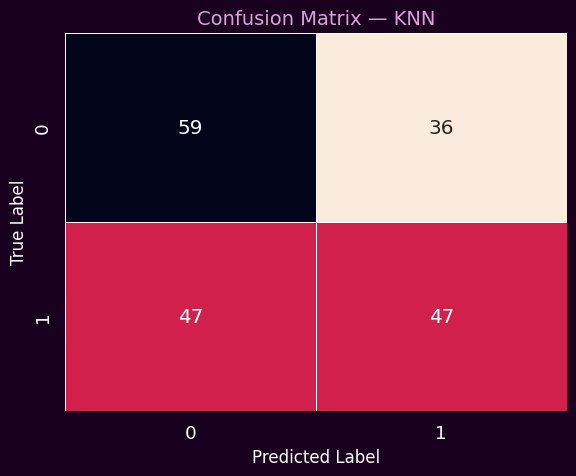

In [68]:
# Построение и визуализация confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Настройка стиля визуализации
plt.figure(figsize=(6, 5))
sns.set(style='darkgrid', font_scale=1.2)

# Оттенки неонового фиолетового — от яркого к светлому
custom_cmap = sns.color_palette("rocket_r", as_cmap=True)

sns.heatmap(conf_matrix, annot=True, fmt='d',
            cmap=custom_cmap, linewidths=0.5,
            linecolor='white', cbar=False)

plt.title(f'Confusion Matrix — {name}', fontsize=14, color='#DDA0DD')  # светло-фиолетовый
plt.xlabel('Predicted Label', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')

# Тёмный фон
plt.gca().set_facecolor('#1a001f')           # глубокий тёмно-фиолетовый
plt.gcf().patch.set_facecolor('#1a001f')

plt.tight_layout()
plt.show()

In [69]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'KNN',
 'Precision': 0.5662650602409639,
 'Recall': 0.5,
 'F1 Score': 0.5310734463276836,
 'Accuracy': 0.5608465608465608,
 'ROC-AUC': np.float64(0.585946248600224)}

**Random Forest**

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
#Обучение и прогноз модели Random Forest

name = 'Random Forest'
model =  RandomForestClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


y_pred

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

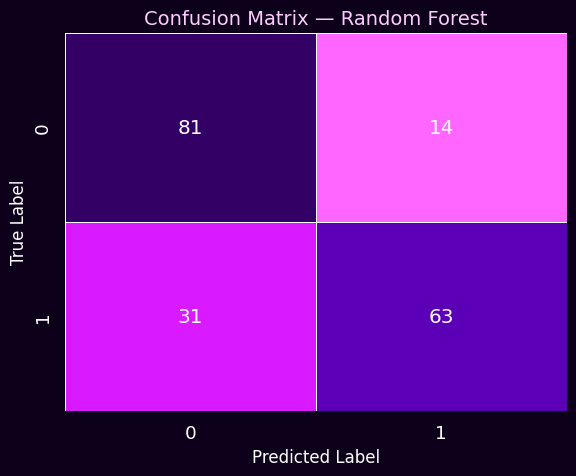

In [74]:
# Построение и визуализация confusion matrix с неоново-фиолетовым градиентом

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Создание пользовательского неоново-фиолетового градиента
neon_purple_cmap = LinearSegmentedColormap.from_list(
    "neon_purple", ["#ff66ff", "#cc00ff", "#6600cc", "#330066"]
)

# Визуализация
plt.figure(figsize=(6, 5))
sns.set(style='white', font_scale=1.2)

sns.heatmap(conf_matrix, annot=True, fmt='d',
            cmap=neon_purple_cmap, linewidths=0.5,
            linecolor='white', cbar=False)

plt.title(f'Confusion Matrix — {name}', fontsize=14, color='#ffccff')
plt.xlabel('Predicted Label', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')

# Тёмный фон графика и области
plt.gca().set_facecolor('#0d001a')
plt.gcf().patch.set_facecolor('#0d001a')

plt.tight_layout()
plt.show()

In [75]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'Random Forest',
 'Precision': 0.8181818181818182,
 'Recall': 0.6702127659574468,
 'F1 Score': 0.7368421052631579,
 'Accuracy': 0.7619047619047619,
 'ROC-AUC': np.float64(0.8526315789473684)}

**Gradient Boosting**

In [76]:
from sklearn.ensemble import  GradientBoostingClassifier

In [77]:
#Обучение и прогноз модели Gradient Boosting

name = 'Gradient Boosting'
model =  GradientBoostingClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])

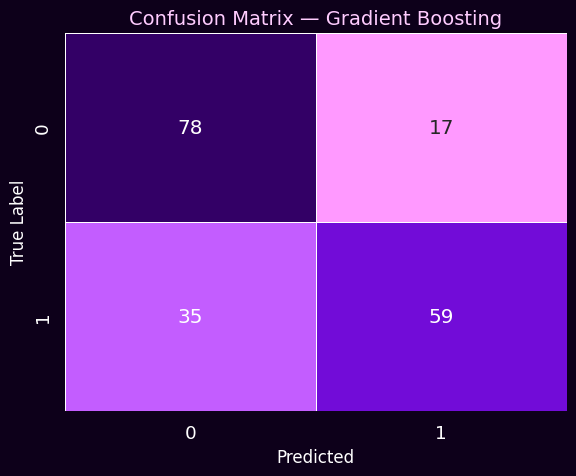

In [79]:
# Построение и визуализация confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Создание пользовательской палитры
neon_purple_cmap = LinearSegmentedColormap.from_list(
    "neon_purple", ["#ff99ff", "#cc66ff", "#9933ff", "#6600cc", "#330066"]
)

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap=neon_purple_cmap,
            linewidths=0.5,
            linecolor='white',
            cbar=False)

plt.title('Confusion Matrix — ' + name, fontsize=14, color='#ffccff')
plt.xlabel('Predicted', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#0d001a')           # фон графика
plt.gcf().patch.set_facecolor('#0d001a')      # фон всей фигуры
plt.tight_layout()
plt.show()

In [80]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'Gradient Boosting',
 'Precision': 0.7763157894736842,
 'Recall': 0.6276595744680851,
 'F1 Score': 0.6941176470588235,
 'Accuracy': 0.7248677248677249,
 'ROC-AUC': np.float64(0.8707726763717805)}

**HistGradientBoosting**

In [81]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [82]:
#Обучение и прогноз модели HistGradientBoosting

name = 'HistGradientBoosting'
model =  HistGradientBoostingClassifier(random_state=RANDOM_STATE)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0])

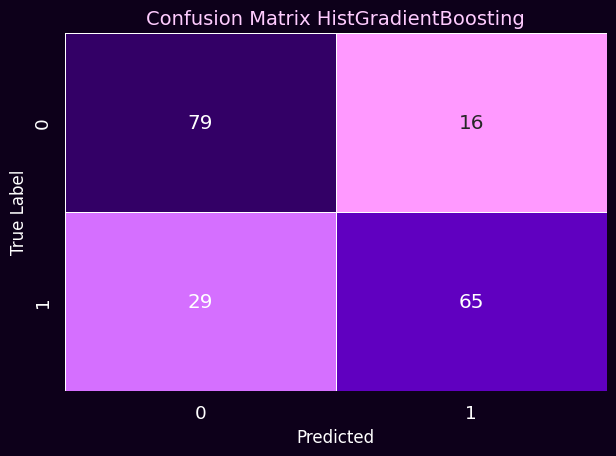

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Пользовательская неоново-фиолетовая цветовая палитра
neon_purple_cmap = LinearSegmentedColormap.from_list(
    "neon_purple", ["#ff99ff", "#cc66ff", "#9933ff", "#6600cc", "#330066"]
)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=neon_purple_cmap,
            linewidths=0.5, linecolor='white', cbar=False)

plt.title('Confusion Matrix ' + name, fontsize=14, color='#ffccff')
plt.xlabel('Predicted', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#0d001a')           # Тёмный фон внутри графика
plt.gcf().patch.set_facecolor('#0d001a')      # Тёмный фон всей фигуры
plt.tight_layout()
plt.show()

In [85]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'HistGradientBoosting',
 'Precision': 0.8024691358024691,
 'Recall': 0.6914893617021277,
 'F1 Score': 0.7428571428571429,
 'Accuracy': 0.7619047619047619,
 'ROC-AUC': np.float64(0.8558790593505039)}

**XGBoost**

In [86]:
from xgboost import XGBClassifier

In [87]:
#Обучение и прогноз модели XGBoost

name = 'XGBoost'
model = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

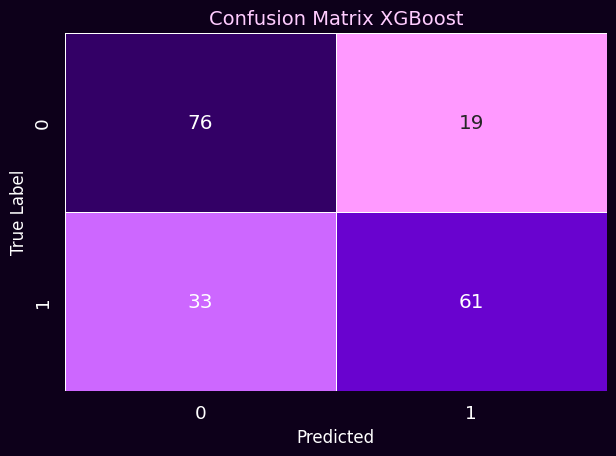

In [89]:
# Построение и визуализация confusion matrix
from matplotlib.colors import LinearSegmentedColormap

# Создание цветовой карты
neon_purple_cmap = LinearSegmentedColormap.from_list(
    "neon_purple", ["#ff99ff", "#cc66ff", "#9933ff", "#6600cc", "#330066"]
)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=neon_purple_cmap,
            linewidths=0.5, linecolor='white', cbar=False)

plt.title('Confusion Matrix ' + name, fontsize=14, color='#ffccff')
plt.xlabel('Predicted', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#0d001a')           # тёмный фон под графиком
plt.gcf().patch.set_facecolor('#0d001a')      # фон всей фигуры
plt.tight_layout()
plt.show()

In [90]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'XGBoost',
 'Precision': 0.7625,
 'Recall': 0.648936170212766,
 'F1 Score': 0.7011494252873564,
 'Accuracy': 0.7248677248677249,
 'ROC-AUC': np.float64(0.8316909294512879)}

**CatBoost**

In [91]:
from catboost import CatBoostClassifier

In [92]:
#Обучение и прогноз модели CatBoost

name = 'CatBoost'
model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

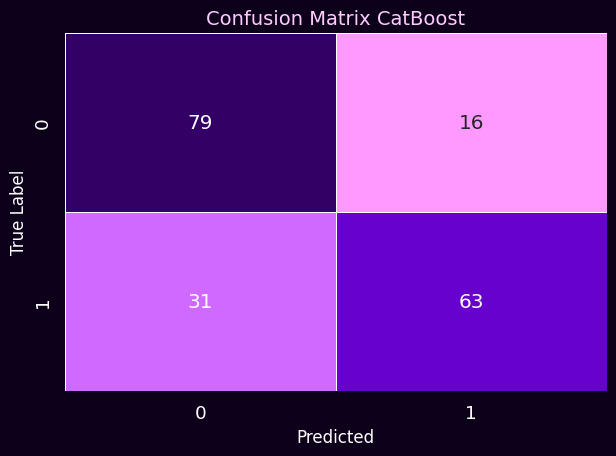

In [94]:
# Построение и визуализация confusion matrix

from matplotlib.colors import LinearSegmentedColormap

# Пользовательская палитра: градиент от розово-фиолетового к тёмному фиолетовому
neon_purple_cmap = LinearSegmentedColormap.from_list(
    "neon_purple", ["#ff99ff", "#cc66ff", "#9933ff", "#6600cc", "#330066"]
)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d',
            cmap=neon_purple_cmap,
            linewidths=0.5, linecolor='white', cbar=False)

plt.title('Confusion Matrix ' + name, fontsize=14, color='#ffccff')
plt.xlabel('Predicted', fontsize=12, color='white')
plt.ylabel('True Label', fontsize=12, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('#0d001a')            # фон внутри графика
plt.gcf().patch.set_facecolor('#0d001a')       # фон всей области
plt.tight_layout()
plt.show()

In [95]:
#Сохранение в общий результат
res = {'Model': name,
       'Precision': precision_score(y_test, y_pred), # точность
       'Recall': recall_score(y_test, y_pred),       # полнота
       'F1 Score': f1_score(y_test, y_pred),         # оценка F1
       'Accuracy': accuracy_score(y_test, y_pred),   # качество модели
       'ROC-AUC': roc_auc_score(y_test, y_proba)  }
results.append(res)
res

{'Model': 'CatBoost',
 'Precision': 0.7974683544303798,
 'Recall': 0.6702127659574468,
 'F1 Score': 0.7283236994219653,
 'Accuracy': 0.7513227513227513,
 'ROC-AUC': np.float64(0.8780515117581187)}

In [96]:
results_df = pd.DataFrame(results)

/tmp/ipython-input-98-2570637916.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('plasma')  # можно также попробовать 'magma', 'inferno'


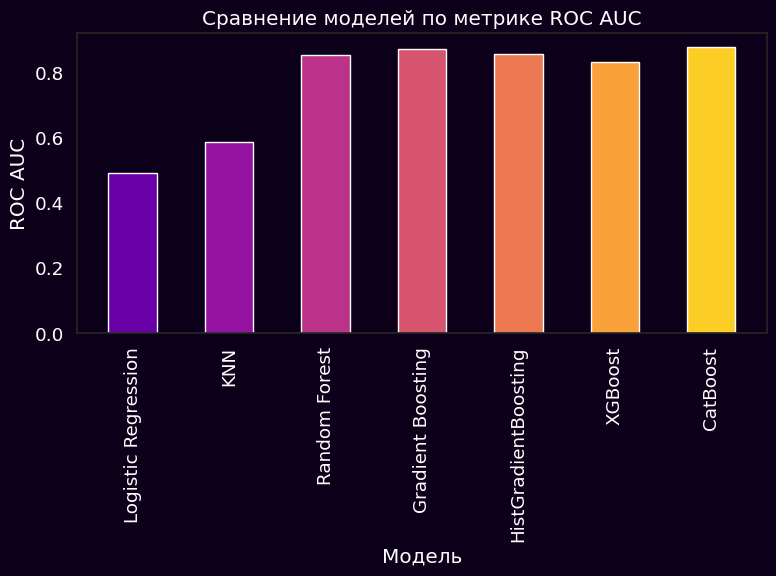

In [98]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

plt.figure(figsize=(8, 6))
plt.title('Сравнение моделей по метрике ROC AUC', color='white')

# Получаем неоново-фиолетовый градиент из встроенной палитры (например, 'plasma' или 'magma')
cmap = get_cmap('plasma')  # можно также попробовать 'magma', 'inferno'
norm = np.linspace(0.2, 0.9, len(results_df))  # нормализация цвета по числу моделей
colors = [cmap(n) for n in norm]

# Визуализация
plt.xticks(rotation=90, color='white')
plt.yticks(color='white')
plt.bar(results_df['Model'], results_df['ROC-AUC'], width=0.5, color=colors)
plt.ylabel('ROC AUC', color='white')
plt.xlabel('Модель', color='white')

# Тёмный фон графика
plt.gca().set_facecolor('#0d001a')            # внутри графика
plt.gcf().patch.set_facecolor('#0d001a')       # общий фон

plt.tight_layout()
plt.show()

In [99]:
print("Результаты классификации:")
results_df

Результаты классификации:


,Model,Precision,Recall,F1 Score,Accuracy,ROC-AUC
0,Logistic Regression,0.497354,1.000000,0.664311,0.497354,0.489362
1,KNN,0.566265,0.500000,0.531073,0.560847,0.585946
2,Random Forest,0.818182,0.670213,0.736842,0.761905,0.852632
3,Gradient Boosting,0.776316,0.627660,0.694118,0.724868,0.870773
4,HistGradientBoosting,0.802469,0.691489,0.742857,0.761905,0.855879
5,XGBoost,0.762500,0.648936,0.701149,0.724868,0.831691
6,CatBoost,0.797468,0.670213,0.728324,0.751323,0.878052


In [100]:
print(f"Наилучший результат \n{results_df[results_df['ROC-AUC']==results_df['ROC-AUC'].max()]}")

Наилучший результат 
      Model  Precision    Recall  F1 Score  Accuracy   ROC-AUC
6  CatBoost   0.797468  0.670213  0.728324  0.751323  0.878052


# **Комментарии к метрикам**
* **Precision (точность)** — это насколько часто модель не промахивается, когда говорит "это положительный класс".
Самая высокая точность у Random Forest (0.818) и HistGradientBoosting (0.802) — то есть, если модель говорит "да", то она в основном права.

* **Recall (полнота)** — показывает, сколько настоящих положительных модель вообще смогла найти.
У Logistic Regression здесь максимум — 1.0, но она при этом просто помечает почти всё как положительное, поэтому и точность (precision) у неё низкая.

* **F1 Score** — это баланс между точностью и полнотой, чтобы не было перекоса в одну сторону.
Лучше всего себя показали Random Forest, HistGradientBoosting и CatBoost — у них F1 выше 0.72, что значит хорошее сочетание обеих метрик.

* **ROC-AUC** — это насколько уверенно модель различает классы вообще, независимо от порога.
Если AUC выше 0.85 — это уже круто. У CatBoost он вообще 0.878 — то есть он лучший в этом плане.

**🟣 Общий вывод**
Если коротко:
* **CatBoost** — лучший среди всех: у него и AUC высокий, и F1 сбалансирован, высокая точность.
* **HistGradientBoosting** и **Random Forest** — тоже очень неплохие, особенно если нужен хороший результат без лишних сложностей.
* **Logistic Regression** и **KNN** — слабоваты на этих данных, скорее всего из-за того, что они не справляются с более сложными границами классов.

